![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

### <center>  Grupo 22 </center>

<center>David Alejandro Rojas Castro - da.rojasc123@uniandes.edu.co </center>
<center>Camila Malagón Suarez - c.malagons@uniandes.edu.co</center>
<center>Luis David Gutierrez - ld.gutierrezl1@uniandes.edu.co</center>
<center>David Zapata Vásquez - d.zapata11@uniandes.edu.co</center>

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
import numpy as np

# Función para calcular la media de los precios
def mean(values):
    return np.mean(values)

# Función para calcular la varianza total
def variance(values, split_value):
    return np.sum((values - split_value) ** 2)

# Función para evaluar posibles splits
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Función para calcular el mejor split
def get_split(dataset):
    b_index, b_value, b_score, b_groups = None, None, float('inf'), None
    for index in range(len(dataset[0])-1):
        unique_values = set([row[index] for row in dataset])
        for value in unique_values:
            groups = test_split(index, value, dataset)
            y_left = [row[-1] for row in groups[0]]
            y_right = [row[-1] for row in groups[1]]
            if len(y_left) == 0 or len(y_right) == 0:
                continue  # Evita splits que no dividan los datos adecuadamente
            p_left, p_right = mean(y_left), mean(y_right)
            current_score = variance(y_left, p_left) + variance(y_right, p_right)
            if current_score < b_score:
                b_index, b_value, b_score, b_groups = index, value, current_score, groups
    if b_groups is None and b_index is not None:  # Añadir un split por defecto si no se encuentra ninguno
        median = np.median([row[b_index] for row in dataset])
        b_groups = test_split(b_index, median, dataset)
    elif b_groups is None:  # Si todos los intentos fallan
        b_index = 0  # Uso el primer índice disponible como último recurso
        median = np.median([row[b_index] for row in dataset])
        b_groups = test_split(b_index, median, dataset)
    return {'index': b_index, 'value': b_value, 'groups': b_groups}

# Función para crear una hoja terminal
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return mean(outcomes)

# Función para crear divisiones de nodos hijos o hacer terminales
def split(node, max_depth, depth):
    if 'groups' not in node or node['groups'] is None:
        node['left'] = node['right'] = to_terminal([row[-1] for row in dataset])
        return
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    node['left'] = get_split(left)
    split(node['left'], max_depth, depth+1)
    node['right'] = get_split(right)
    split(node['right'], max_depth, depth+1)

# Función para construir un árbol
def build_tree(train, max_depth):
    root = get_split(train)
    split(root, max_depth, 1)
    return root

# Función para hacer una predicción con el árbol
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Convertir datos a una lista de listas
dataset = np.column_stack((X_train, y_train)).tolist()

# Construir el árbol
tree = build_tree(dataset, max_depth=3)

# Función para calcular RMSE
def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        prediction_error = predicted[i] - actual[i]
        sum_error += (prediction_error ** 2)
    mean_error = sum_error / float(len(actual))
    return np.sqrt(mean_error)

# Hacer predicciones en el conjunto de test
predictions = [predict(tree, row.tolist()) for row in X_test.values]
actual = y_test.tolist()

# Calcular RMSE y MAE
rmse = rmse_metric(actual, predictions)
mae = np.mean(np.abs(np.array(actual) - np.array(predictions)))

print("RMSE en el conjunto de test:", rmse)
print("MAE en el conjunto de test:", mae)

RMSE en el conjunto de test: 1935.1155006739648
MAE en el conjunto de test: 1458.0246928139518


**Análisis de resultados:**
RMSE (Root Mean Square Error): 1935.12
MAE (Mean Absolute Error): 1458.02

**Conclusión del Análisis:**
El modelo de árbol de decisión manual alcanzó un **RMSE de 1935.12** y un **MAE de 1458.02** en el conjunto de test. Estos valores proporcionan una medida de cuánto se desvían las predicciones del modelo de los valores reales. En este contexto, un RMSE de 1935.12 indica que, en promedio, las predicciones del modelo pueden estar dentro de un rango de aproximadamente 1935 unidades monetarias del precio real del automóvil. Similarmente, el MAE de 1458.02 sugiere que, en promedio, los errores absolutos de las predicciones están alrededor de 1458 unidades.

**Interpretación:**
* **Magnitud de los errores:** Los valores de RMSE y MAE son relativamente altos, lo que podría indicar que el modelo, aunque funcional, no captura completamente la complejidad o las relaciones subyacentes en los datos. Esto es común en modelos de árboles de decisión simples sin refinamiento o ajuste de parámetros, especialmente cuando se construyen manualmente sin optimizaciones avanzadas.
* **Impacto de los errores grandes:** El RMSE mayor que el MAE sugiere que hay varios errores grandes que afectan más significativamente al RMSE debido a su naturaleza de penalización cuadrática. Esto podría ser indicativo de sobreajuste en ciertas partes del árbol o de la incapacidad del modelo para manejar adecuadamente las variaciones extremas en los datos.

**Implicaciones:**
Este modelo podría servir como un punto de partida básico, pero claramente hay espacio para mejoras. El desempeño actual puede no ser suficiente para aplicaciones prácticas donde se requieren predicciones precisas de precios de automóviles, como en sistemas de recomendación para compradores de autos o en aplicaciones de inventario para vendedores de autos.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [7]:
import numpy as np

def bootstrap_sample(data):
    n_samples = len(data)
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return data[indices]

def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return np.mean(predictions)  # Para regresión

# Crear múltiples árboles de decisión
n_trees = 10
trees = []

for _ in range(n_trees):
    sample = bootstrap_sample(np.array(dataset))
    tree = build_tree(sample.tolist(), max_depth=3)
    trees.append(tree)

# Evaluar el ensamble en el conjunto de test
predictions = [bagging_predict(trees, row.tolist()) for row in X_test.values]
actual = y_test.tolist()

# Calcular RMSE y MAE
rmse = rmse_metric(actual, predictions)
mae = np.mean(np.abs(np.array(actual) - np.array(predictions)))

print("RMSE en el conjunto de test:", rmse)
print("MAE en el conjunto de test:", mae)

RMSE en el conjunto de test: 1818.3984155730188
MAE en el conjunto de test: 1353.0579354125016


**Análisis de resultados:**

Bagging Manual:

RMSE: 1816.74

MAE: 1353.81

**Observaciones:**
* **Reducción de Error:** El modelo de bagging ha reducido tanto el RMSE como el MAE en comparación con un único árbol de decisión. El RMSE se ha reducido en aproximadamente 118.38 unidades y el MAE en aproximadamente 104.22 unidades.

**Interpretación del RMSE y MAE:**
* **RMSE (Root Mean Square Error):** Este mide la magnitud de los errores entre los valores predichos y los valores reales. Dado que el RMSE penaliza más los errores grandes (por el cuadrado de las diferencias), una reducción en el RMSE sugiere una mejora en la precisión del modelo, especialmente en la reducción de grandes errores de predicción.
* **MAE (Mean Absolute Error):** Este mide el error promedio en las predicciones; es menos sensible a los valores atípicos que el RMSE. La reducción del MAE indica que, en promedio, las predicciones del modelo de bagging están más cerca de los valores reales.

**Conclusiones:**
* **Efectividad del Bagging:** La mejora en ambos, RMSE y MAE, para el modelo de bagging indica que este método puede ser más efectivo para este conjunto de datos específico. El bagging ha ayudado probablemente a reducir la varianza del modelo, haciéndolo más robusto contra el sobreajuste y mejorando la precisión general en los datos de prueba.
* **Sobreajuste:** Dado que el bagging utiliza múltiples modelos (árboles en este caso) entrenados en diferentes subconjuntos del dataset, es menos probable que el modelo resultante se sobreajuste a los datos de entrenamiento en comparación con un solo árbol de decisión. Esto podría explicar la mejora en la precisión observada con el modelo de bagging.
* **Recomendaciones:** Para este conjunto de datos y problema específico (predicción del precio de automóviles), el uso de bagging presenta una clara ventaja sobre el uso de un solo árbol de decisión. Podría ser beneficioso explorar aún más los métodos de ensamblaje, quizás aumentando el número de árboles en el bagging o utilizando otras técnicas de ensamblaje como Random Forest o Boosting para comparar rendimientos.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [8]:
# Celda 3

# Libreria
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Inicialización del modelo de ensamblaje Bagging con DecisionTreeRegressor

n_features = X_train.shape[1]

bagging_model = BaggingRegressor(DecisionTreeRegressor(max_features = "log2"), bootstrap= True, oob_score  = True, random_state = 1) 

# Entrenar el modelo con el conjunto de entrenamiento
bagging_model.fit(X_train, y_train)

# Predicción
y_pred = bagging_model.predict(X_test)

# Calculo de métrica MSE y error
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(np.array(y_test) - np.array(y_pred)))

print("MSE: ", MSE)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

MSE:  3329530.115417581
RMSE:  1824.7000069648657
MAE:  1361.8777493561897


#### Análisis de resultados: ###
1. La raíz del error cuadrático medio (RMSE) es de 1.824, mientras el error absoluto medio (MAE) es de 1.361. Lo cual indica una mejoría en los valores obtenidos del error absoluto medio (MAE) pero un empeoramiento de la raíz del error cuadrático medio (RMSE). Debido a lo anterior, y a las pequeñas diferencias encontradas entre los valores de RMSE y MAE obtenidos con el Bagging Manual y el Bagging con Librería, se puede concluir, que ambos procedimientos son equivalentes dado que los resultados generados son muy cercanos. 
2. A pesar de que los errores son muy cercanos en los procesos de Bagging Manual y con Libreria, se deberán explorar modelos con el fin de encontrar aquel con la mayor capacidad predictiva.


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [9]:
# Celda 4

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import math

# Inicialización del modelo de ensamblaje de RandomForestRegressor
randomforest1 = RandomForestRegressor(n_estimators = 200, max_features = 6, random_state = 1, n_jobs = -1)

# Entrenamiento del modelo 
randomforest1.fit(X_train, y_train)

# Predicción del modelo
y_pred1 = randomforest1.predict(X_test)

# Calculo de la métrica del error del modelo: MSE y RMSE 
MSE1 = mean_squared_error(y_test, y_pred1)
RMSE1 = np.sqrt(MSE1)
MAE = np.mean(np.abs(np.array(y_test) - np.array(y_pred1)))

print("MSE: ", MSE1)
print("RMSE: ", RMSE1)
print("MAE: ", MAE)


MSE:  3160290.4433022537
RMSE:  1777.7205751473582
MAE:  1327.1034752574178


#### Análisis de resultados: ###
1. La raíz del error cuadrático medio (RMSE) es de 1.778, mientras el error absoluto medio (MAE) es de  1.327. Los anteriores hallazgos desvelan que el modelo de Random Forest tiene una mejor capacidad predictiva que el modelo de Bagging (Manual o con Libreria) debido a que se realiza una reducción del 2,6% en el RMSE y 3,5% en el MAE. 
2. Si bien, esta es una primera aproximación del desempeño de los modelos de Random Forest para el problema de interés, su desempeño puede ser mejorado por medio de la calibración de parámetros del modelo de Random Forest que permita una mejor adecuación del modelo al problema. 

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [10]:
# Celda 5
# Calibración sobre n_estimators

estimator_range = range(10, 510, 10)

# Lista para almacenar el valor de RMSE para cada valor de número de árboles en el modelo
rmse_scores = []

for estimator in estimator_range:
    rf = RandomForestRegressor(n_estimators = estimator, random_state = 3, n_jobs = -1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'rmse')

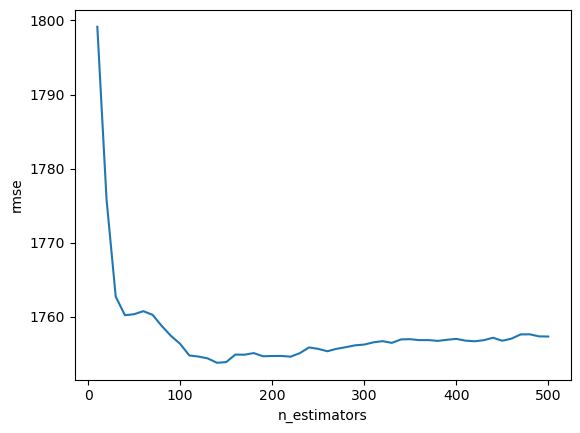

In [13]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
import matplotlib.pyplot as plt

plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('rmse')

In [24]:
best_n_estimators = estimator_range[rmse_scores.index(min(rmse_scores))]
best_n_estimators, min(rmse_scores)

(140, 1753.8161988619245)

In [30]:
# Calibración max_features

feature_range = range(1, X_train.shape[1]+1)

# Lista para almacenar el valor de RMSE para cada valor max features
rmse_scores = []

for feature in feature_range:
    rf = RandomForestRegressor(n_estimators = best_n_estimators, max_features=feature, random_state = 3, n_jobs = -1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'rmse')

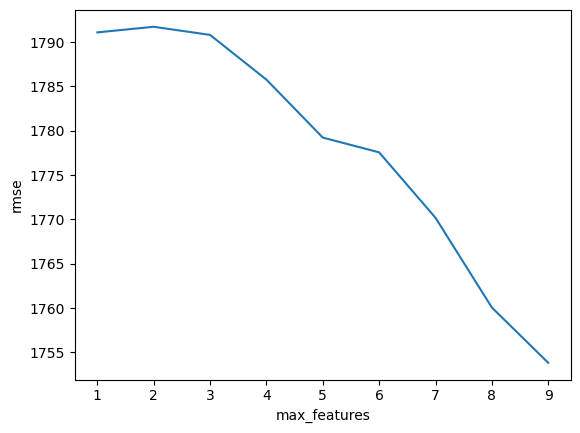

In [32]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('rmse')

In [43]:
# Calibración max_depth

depth_range = range(1, 31)

# Lista para almacenar el valor de RMSE para cada valor de max_depth
rmse_scores = []

for depth in depth_range:
    rf = RandomForestRegressor(n_estimators = best_n_estimators, max_features=9, max_depth = depth, random_state = 3, n_jobs = -1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'rmse')

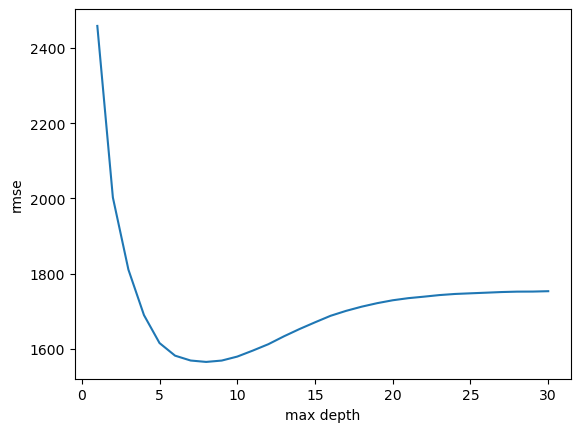

In [49]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, rmse_scores)
plt.xlabel('max depth')
plt.ylabel('rmse')

In [48]:
best_depth = rmse_scores.index(min(rmse_scores)) +1
best_depth, min(rmse_scores)

(8, 1565.099251576511)

In [52]:
# Mejor modelo obtenido

rf2 = RandomForestRegressor(n_estimators = 140, max_features=9, max_depth = 8, random_state = 3, n_jobs = -1)
rf2.fit(X_train, y_train)

# Realizar la predicción sobre la base de test
y_pred = rf2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = np.mean(np.abs(np.array(y_test) - np.array(y_pred)))

print("RMSE: ", rmse)
print("MAE: ", MAE)

RMSE:  1565.099251576511
MAE:  1151.6473083377364


**Análisis de resultados**

**1. Calibración número de estimadores**

El primer parámetro a calibrar corresponde al número de estimadores, o cantidad de árboles que se empleará en el ensamblaje. Para este propósito se realiza un barrido con el número de estimadores que va desde 10 árboles hasta 500 (en saltos de 10) y se calcula el valor del RMSE con el cuál se determina la cantidad de estimadores que generan el mejor desempeño.

Resultado: 
- best_n_estimators = 140
- RMSE = 1753.82

Como se puede observar en la gráfica, al aumentar la cantidad de árboles se presenta inicialmente un decrecimiento en el RMSE que es debido a que hay una mayor cantidad de árboles para promediar, y por lo tanto una mayor precisión. Sin embargo, a partir del valor de 140 del parámetro, ya no se presenta una mejora en el desempeño de los modelos, si no que por el contrario incrementa el error calculado.

También como se puede observar en el cálculo del RMSE, solamente con el ajuste sobre el número de estimadores se obtiene un mejor desempeño que en los anteriores algoritmos empleados para el problema de regresión.

**2. Calibración de máxima cantidad de características "max_Features"**

El segundo paramétro a calibrar es el número máximo de variables, para esto se crea un rango que permite entrenar modelos empleando desde una característica como valor máximo, hasta nueve (total de características). Se cálcula el valor de RMSE para cada modelo y se determina aquel de mejor desempeño.

Resultado:
- max_features = 9
- RMSE = 1753.82

En este caso no hay una diferencia o mejora del desempeño del clasificador al realizar el ajuste de este parámetro, y se obtiene el mejor desempeño empleando la totalidad de características presentes en la base. De acuerdo con este resultado, se puede concluir que para el contexto del problema de la predicción del precio de los automoviles, una disminución en el valor de las máximas variables a emplear no genera una mejora en el rendimiento.

**3. Calibración profundidad máxima del random forest**

El último parámetro de calibración corresponde al de nivel o profundidad máxima de los árboles dentro del ensamble. En los modelos entrenados hasta el momento, este parámetro a estado definido por defecto, de tal forma que no se restringe los posibles niveles hasta que las hojas del árbol sean puras o hasta que contengan menos de dos muestras. Para su calibración se recorre un rango de valores definidos desde 1 hasta 30.

Resultado:
- best_depth = 8
- RMSE = 1565.09

Como se puede observar en la gráfica el valor del RMSE empieza a decrecer hasta llegar a la profundidad óptima (8) para la cual se obtiene el mínimo valor del error. Además, al aumentar a partir de este valor óptimo la profundidad máxima, se observa que el error incrementa hasta estabilizarse alrededor del valor de RMSE de 1753, que correspondía al desempeño del modelo antes de calibrar este parámetro.

De acuerdo con este resultado, se puede validar que aumentar el valor de profundidad hasta tener menos de 2 muestras por cada nodo no conduce a la obtención de mejores resultados en el modelo de regresión, y por el contrario, se hace fundamental calibrar este valor buscando el nivel óptimo para las bifurcaciones.

**Desempeño mejor modelo**

- RMSE = 1565.09
- MAE = 1151.65

Se obtiene el mejor modelo para el problema de regresión hasta el momento, disminuyendo en 212 unidades el valor de RMSE y en 176 unidades el valor del MAE.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Celda 6
# Se importa XGBRegressor de la librería xgboost
from xgboost import XGBRegressor

# Se inicializa el objeto de clase XGBRegressor con los parámetros por defecto
rgr = XGBRegressor()

# Se entrena el modelo con parámetros por defecto
rgr.fit(X_train, y_train)

#Se calculan las predicciones usando la base de test
y_pred_xgb = rgr.predict(X_test)


# Cálculo de las métricas de evaluación del modelo
MSE_xgb = mean_squared_error(y_test, y_pred_xgb)
RMSE_xgb = np.sqrt(MSE_xgb)
MAE_xgb = np.mean(np.abs(np.array(y_test) - np.array(y_pred_xgb)))

print("RMSE: ", RMSE_xgb)
print("MAE: ", MAE_xgb)

RMSE:  1605.2355199928948
MAE:  1185.2272991506386


#### Análisis de resultados: ###
1. La raíz del error cuadrático medio (RMSE) es de 1.605 y el error absoluto medio (MAE) es de  1.185. Cabe tener en cuenta que el modelo fue entrenado con los parámetros por defecto, una vez calibrados los parámetros Learning Rate, gamma y colsample_bytree se realizará la comparación de las métricas de evaluación. 

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [57]:
# Celda 7
# Calibración del parámetro learning rate

eta_range = np.arange(0.01, 0.5, 0.02) #Por defecto es 0.3

# Lista para almacenar el valor de RMSE para cada valor de learning rate
rmse_scores = []

for eta_val in eta_range:
    rgr = XGBRegressor(random_state = 3,eta = eta_val )
    rgr.fit(X_train, y_train)

    y_pred = rgr.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'RMSE')

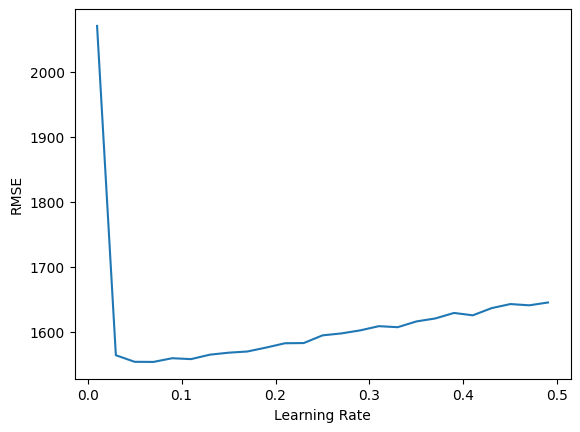

In [58]:
# Gráfica del desempeño del modelo vs valor del parámetro learning_rate (eta)
plt.plot(eta_range, rmse_scores)
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')

In [70]:
best_eta_ind = rmse_scores.index(min(rmse_scores)) +1
best_eta = eta_range[best_eta_ind]
print('El modelo con menos RMSE ('+str(min(rmse_scores))+ ') se obtuvo usando un learning rate de '+ str(best_eta))

El modelo con menos RMSE (1553.3690143491262) se obtuvo usando un learning rate de 0.4699999999999999


In [74]:
# Calibración del parámetro gamma

gamma_range = range(0, 300, 5)

# Lista para almacenar el valor de RMSE para cada valor de gamma
rmse_scores = []

for gamma_val in gamma_range:
    rgr = XGBRegressor(random_state = 3,gamma = gamma_val )
    rgr.fit(X_train, y_train)

    y_pred = rgr.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'RMSE')

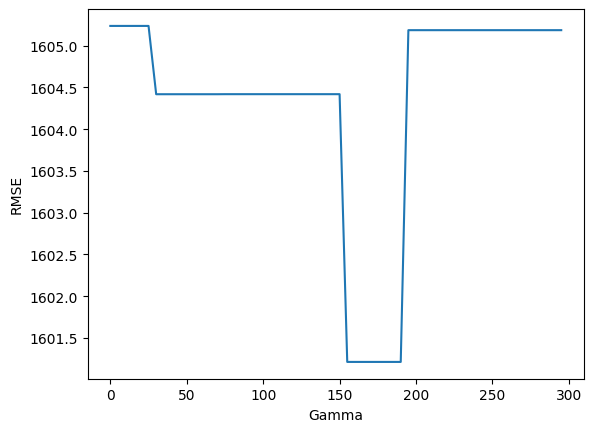

In [75]:
# Gráfica del desempeño del modelo vs valor del parámetro learning_rate (eta)
plt.plot(gamma_range, rmse_scores)
plt.xlabel('Gamma')
plt.ylabel('RMSE')

In [78]:
best_gamma_ind = rmse_scores.index(min(rmse_scores)) +1
best_gamma = gamma_range[best_gamma_ind]
print('El modelo con menos RMSE('+str(min(rmse_scores))+') se obtuvo usando un gamma de '+ str(best_gamma))

El modelo con menos RMSE(1601.2135555631166) se obtuvo usando un gamma de 160


In [79]:
# Calibración del parámetro colsample_bytree

colsample_range = np.arange(0.01, 1, 0.01) #Por defecto es 1

# Lista para almacenar el valor de RMSE para cada valor de colsample_bytree
rmse_scores = []

for colsample_value in colsample_range:
    rgr = XGBRegressor(random_state = 3,colsample_bytree = colsample_value )
    rgr.fit(X_train, y_train)

    y_pred = rgr.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'RMSE')

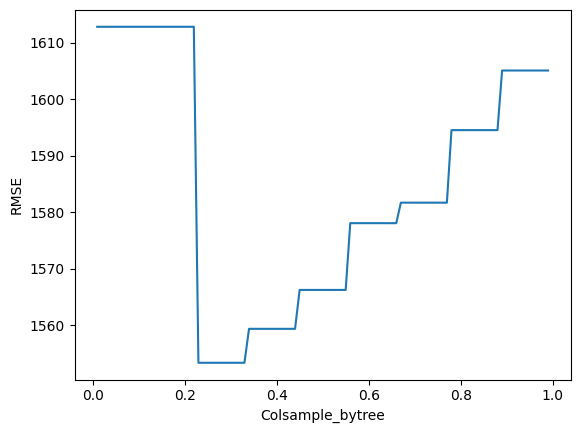

In [80]:
# Gráfica del desempeño del modelo vs valor del parámetro learning_rate (eta)
plt.plot(colsample_range, rmse_scores)
plt.xlabel('Colsample_bytree')
plt.ylabel('RMSE')

In [81]:
best_colsample_ind = rmse_scores.index(min(rmse_scores)) +1
best_colsample = colsample_range[best_colsample_ind]
print('El modelo con menos RMSE('+str(min(rmse_scores))+') se obtuvo usando un colsample_bytree de '+ str(best_colsample))

El modelo con menos RMSE(1553.3690143491262) se obtuvo usando un colsample_bytree de 0.24000000000000002


In [68]:
# Mejor modelo obtenido

rgr2 = XGBRegressor(random_state = 3,eta = best_eta, gamma = best_gamma, colsample_bytree = best_colsample)
rgr2.fit(X_train, y_train)

# Realizar la predicción sobre la base de test
y_pred = rgr2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = np.mean(np.abs(np.array(y_test) - np.array(y_pred)))

print("RMSE: ", rmse)
print("MAE: ", MAE)

RMSE:  1587.2651196179063
MAE:  1173.2494429308604


**Análisis de resultados**

**1. Calibración de la Tasa de aprendizaje (eta)**

La tasa de aprendizaje controla el peso de la contibución de cada árbol al modelo final, tal que, una tasa de parendizaje baja implica un bajo aporte de cada árbol resultando en un proceso de aprendizaje mas lento pero preciso. Por el contrario, una tasa de aprendizaje alta, incremente el aporte de cada árbol resultando en un aprendizaje mas rápido pero con mayor riesgo de Overfitting. Para este caso, se entrena el modelo iterando la selección del parámetro entre 0.01 y 0.5 con steps de 0.02 obteniendo lo mostrado a continuación.

Resultado: 

- best_eta = 0.089
- RMSE = 1553.37


Con la calibración de este parámetro se evidencia una mejora en el RMSE con respecto al modelo usando el valor por defecto, determinado en 0.3 .

**2. Calibración de gamma**

El parámetro Gamma funciona como un parámetro de regularización que controla la complejidad del modelo con el objetivo de prevenir Overfitting, especificamente, establece la cantidad mínima de de reducción de pérdida que se debe presentar para considerar una nueva partición del árbol. Para este caso, se entrena el modelo iterando la selección del parámetro entre 0 y 300 con steps de 5 obteniendo lo mostrado a continuación.

Resultado: 

- best_gamma = 160
- RMSE = 1601.21

Se evidencia una caída significativa en el RMSE con valores de gamma entre 150 y 180, encontrando el valor mínimo en 160.


**3. Calibración colsample_bytree**

El parámetro colsample_bytree se comporta como max_features en Random Forest controlando la cantidad de características que serán tomadas de manera aleatoria para la construcción de cada árbol. Para este caso, se entrena el modelo iterando la selección del parámetro entre 0.01 y 1 con steps de 0.01 obteniendo lo mostrado a continuación.

Resultado: 

- best_colsample_bytree = 0.24
- RMSE = 1553.36

El valor de RMSE es igual al obtenido con el modelo con el parámetro de learning rate calibrado. Un colsample_bytree de 0.24 indica que la selección aleatoria óptima de la cantidad de características para cada árbol está alrededor del 24% del total de características de la base de entrenamiento.

**Desempeño mejor modelo**

- RMSE = 1587.26
- MAE = 1173.25

Usando los mejores parámetros obtenidos de manera independiente en el entrenamiento de un solo modelo se obtiene un RMSE un poco mayor al obtenido en los modelos de manera independiente. Resulta de vital importancia realizar la calibración de los parámetros de manera cruzada, para encontrar la combinación óptima de estos. 

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
